In [300]:
! pip install pandas numpy scikit-learn matplotlib seaborn xgboost

13400.99s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 2.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import (
    MinMaxScaler,
    LabelEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler
)

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    confusion_matrix,
    classification_report,
)
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
    LassoCV,
    RidgeCV,
    LogisticRegression,
)
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import numpy as np

In [2]:
df_12 = pd.read_csv("data/season_12_data.csv")
df_13 = pd.read_csv("data/season_13_data.csv")

In [80]:
df_12.head()

,Name,Class,Role,Tier,Trend,Win %,Role %,Pick %,Ban %,KDA
0,Aatrox,Fighter,TOP,A,6.52,49.97%,94.62%,4.43%,Blue (0.83%)/Red (1.2%),1.97
1,Ahri,Mage,MID,A,-0.24,49.93%,93.47%,4.62%,Blue (0.2%)/Red (0.84%),2.56
2,Akali,Assassin,MID,S,6.51,48.59%,65.65%,8.16%,Blue (6.51%)/Red (6.37%),2.34
3,Akali,Assassin,TOP,A,3.34,48.57%,34.06%,4.24%,Blue (5.57%)/Red (7.31%),2.04
4,Akshan,Marksman,MID,S,0.65,51.46%,58.01%,4.83%,Blue (5.07%)/Red (16.84%),2.23


In [81]:
df_13.head()

,Name,Class,Role,Tier,Trend,Win %,Role %,Pick %,Ban %,KDA
0,Aatrox,Fighter,TOP,S,-31.86,47.68%,91.63%,6.62%,Blue (9.8%)/Red (2.18%),1.77
1,Ahri,Mage,MID,S,4.55,49.50%,94.65%,5.81%,Blue (1.54%)/Red (0.19%),2.58
2,Akali,Assassin,MID,S,4.33,48.41%,75.74%,8.11%,Blue (5.74%)/Red (7.28%),2.37
3,Akali,Assassin,TOP,C,-1.51,45.92%,23.50%,2.55%,Blue (0.47%)/Red (12.55%),2.00
4,Akshan,Marksman,MID,A,0.34,51.62%,66.03%,2.75%,Blue (0.06%)/Red (3.73%),2.26


In [3]:
keys_to_strip = [key for key in df_12.keys() if "%" in key and key != "Ban %"]
keys_to_strip

['Win %', 'Role %', 'Pick %']

In [4]:
df_12[keys_to_strip].isna().sum()

Win %     0
Role %    0
Pick %    0
dtype: int64

In [5]:
def strip_percentage(df, columns):
    for col in columns:
        values = []
        for val in df[col]:
            values.append(float(val.split("%")[0]) if type(val) != float else np.nan)
        df[col] = values

In [6]:
import re

def handle_ban(df):
    values = []
    for val in df["Ban %"]:
        if type(val) == float:
            # nan
            values.append(np.nan)
        else:
            numbers = [float(n) for n in re.findall(r"\d+\.\d+", val)]
            values.append(sum(numbers))

    df["Ban %"] = values



In [7]:
strip_percentage(df_12, keys_to_strip)
strip_percentage(df_13, keys_to_strip)

In [8]:
handle_ban(df_12)
handle_ban(df_13)

In [9]:
df_12.head()

,Name,Class,Role,Tier,Trend,Win %,Role %,Pick %,Ban %,KDA
0,Aatrox,Fighter,TOP,A,6.52,49.97,94.62,4.43,2.03,1.97
1,Ahri,Mage,MID,A,-0.24,49.93,93.47,4.62,1.04,2.56
2,Akali,Assassin,MID,S,6.51,48.59,65.65,8.16,12.88,2.34
3,Akali,Assassin,TOP,A,3.34,48.57,34.06,4.24,12.88,2.04
4,Akshan,Marksman,MID,S,0.65,51.46,58.01,4.83,21.91,2.23


In [10]:
df_13.head()

,Name,Class,Role,Tier,Trend,Win %,Role %,Pick %,Ban %,KDA
0,Aatrox,Fighter,TOP,S,-31.86,47.68,91.63,6.62,11.98,1.77
1,Ahri,Mage,MID,S,4.55,49.50,94.65,5.81,1.73,2.58
2,Akali,Assassin,MID,S,4.33,48.41,75.74,8.11,13.02,2.37
3,Akali,Assassin,TOP,C,-1.51,45.92,23.50,2.55,13.02,2.00
4,Akshan,Marksman,MID,A,0.34,51.62,66.03,2.75,3.79,2.26


In [11]:
for key in df_12.keys():
    if key in ["Name", "Role"]: continue
    df_12[f"{key} (season 12)"] = df_12[key]
    df_12.drop(columns=[key], inplace=True)

for key in df_13.keys():
    if key in ["Name", "Role"]: continue
    df_13[f"{key} (season 13)"] = df_13[key]
    df_13.drop(columns=[key], inplace=True)


In [12]:
# df_12.head()
df_13.head()

,Name,Role,Class (season 13),Tier (season 13),Trend (season 13),Win % (season 13),Role % (season 13),Pick % (season 13),Ban % (season 13),KDA (season 13)
0,Aatrox,TOP,Fighter,S,-31.86,47.68,91.63,6.62,11.98,1.77
1,Ahri,MID,Mage,S,4.55,49.50,94.65,5.81,1.73,2.58
2,Akali,MID,Assassin,S,4.33,48.41,75.74,8.11,13.02,2.37
3,Akali,TOP,Assassin,C,-1.51,45.92,23.50,2.55,13.02,2.00
4,Akshan,MID,Marksman,A,0.34,51.62,66.03,2.75,3.79,2.26


In [13]:
df = df_12.merge(df_13, on=["Name", "Role"], how="outer")
df.head()

,Name,Role,Class (season 12),Tier (season 12),Trend (season 12),Win % (season 12),Role % (season 12),Pick % (season 12),Ban % (season 12),KDA (season 12),Class (season 13),Tier (season 13),Trend (season 13),Win % (season 13),Role % (season 13),Pick % (season 13),Ban % (season 13),KDA (season 13)
0,Aatrox,TOP,Fighter,A,6.52,49.97,94.62,4.43,2.03,1.97,Fighter,S,-31.86,47.68,91.63,6.62,11.98,1.77
1,Ahri,MID,Mage,A,-0.24,49.93,93.47,4.62,1.04,2.56,Mage,S,4.55,49.50,94.65,5.81,1.73,2.58
2,Akali,MID,Assassin,S,6.51,48.59,65.65,8.16,12.88,2.34,Assassin,S,4.33,48.41,75.74,8.11,13.02,2.37
3,Akali,TOP,Assassin,A,3.34,48.57,34.06,4.24,12.88,2.04,Assassin,C,-1.51,45.92,23.50,2.55,13.02,2.00
4,Akshan,MID,Marksman,S,0.65,51.46,58.01,4.83,21.91,2.23,Marksman,A,0.34,51.62,66.03,2.75,3.79,2.26


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                258 non-null    object 
 1   Role                258 non-null    object 
 2   Class (season 12)   231 non-null    object 
 3   Tier (season 12)    232 non-null    object 
 4   Trend (season 12)   232 non-null    float64
 5   Win % (season 12)   232 non-null    float64
 6   Role % (season 12)  232 non-null    float64
 7   Pick % (season 12)  232 non-null    float64
 8   Ban % (season 12)   232 non-null    float64
 9   KDA (season 12)     232 non-null    float64
 10  Class (season 13)   244 non-null    object 
 11  Tier (season 13)    244 non-null    object 
 12  Trend (season 13)   244 non-null    float64
 13  Win % (season 13)   244 non-null    float64
 14  Role % (season 13)  244 non-null    float64
 15  Pick % (season 13)  244 non-null    float64
 16  Ban % (s

In [15]:
df.isna().sum()

Name                   0
Role                   0
Class (season 12)     27
Tier (season 12)      26
Trend (season 12)     26
Win % (season 12)     26
Role % (season 12)    26
Pick % (season 12)    26
Ban % (season 12)     26
KDA (season 12)       26
Class (season 13)     14
Tier (season 13)      14
Trend (season 13)     14
Win % (season 13)     14
Role % (season 13)    14
Pick % (season 13)    14
Ban % (season 13)     14
KDA (season 13)       14
dtype: int64

In [16]:
df_tmp = df[
    (df["Class (season 12)"].notna()) &
    (df["Class (season 13)"].notna()) &
    (df["Class (season 12)"] != df["Class (season 13)"])]
len(df_tmp)

0

In [19]:
len(df[
    (df["Class (season 12)"].isna()) &
    (df["Class (season 13)"].isna()) 
])

0

<Axes: >

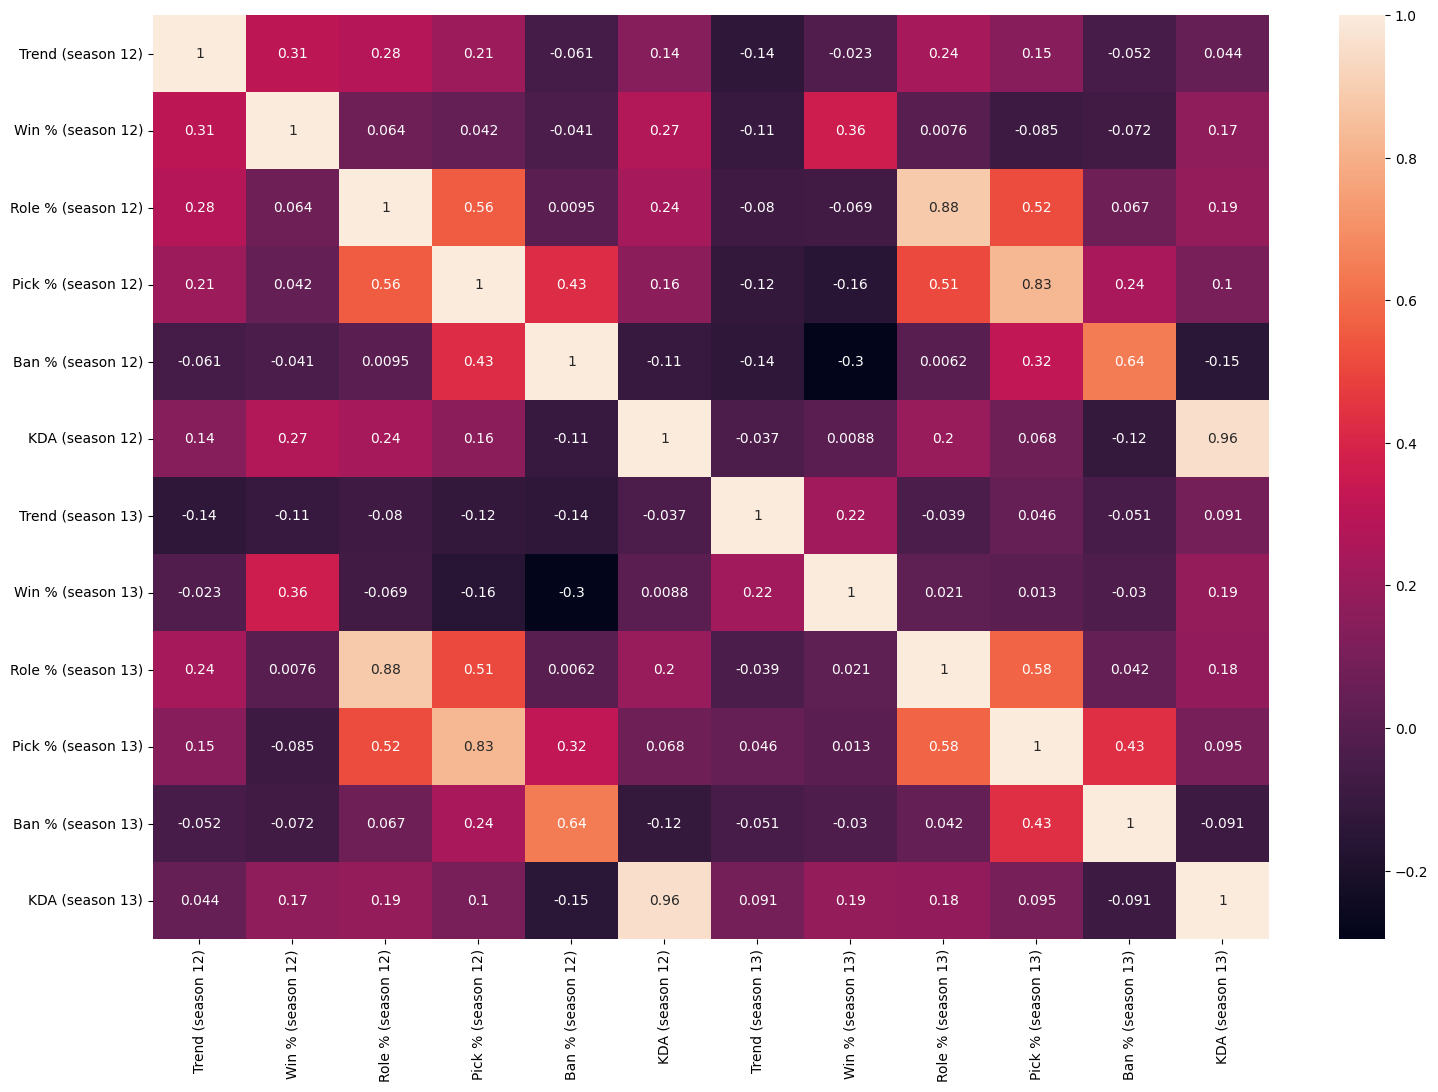

In [315]:
plt.figure(figsize=(18, 12))
sns.heatmap(df.corr(numeric_only=True), annot=True)

In [316]:
# ne postoi nieden heroj kaj sto klasata od edna sezona vo druga se smenila, 
# moze klasata da se imputira preku klasata od drugata sezona

# class, role %, pick %, kda,  moze da se zemat od drugata sezona
# tier, trend, win %, ban % ne moze

In [317]:
label_encoder = LabelEncoder()
df["Class (season 12)"] = label_encoder.fit_transform(df["Class (season 12)"])
df["Class (season 13)"] = label_encoder.transform(df["Class (season 13)"])
label_encoder.classes_

array(['Assassin', 'Fighter', 'Mage', 'Marksman', 'Support', 'Tank', nan],
      dtype=object)

In [318]:
col1 = "Class (season 12)"
col2 = "Class (season 13)"
df[[col1, col2]] = df[[col1, col2]].replace(6, np.nan)

In [319]:
cols = ["Class", "Role %", "Pick %", "KDA"]
for col in cols:
    values_season_12 = df[f"{col} (season 12)"]
    values_season_13 = df[f"{col} (season 13)"]

    to_remove = []
    assert len(values_season_12) == len(values_season_13)
    for i in range(len(values_season_12)):
        val12 = values_season_12[i]
        val13 = values_season_13[i]
        
        if np.isnan(val12) and np.isnan(val13):
            to_remove.append(i)
        if np.isnan(val12):
            values_season_12[i] = val13
        elif np.isnan(val13):
            values_season_13[i] = val12
    
df[f"{col} (season 12)"] = values_season_12    
df[f"{col} (season 13)"] = values_season_13    



/var/folders/g8/z4hc_3fn2m31gh607khncy_h0000gn/T/ipykernel_6611/1344237618.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  values_season_13[i] = val12
/var/folders/g8/z4hc_3fn2m31gh607khncy_h0000gn/T/ipykernel_6611/1344237618.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  values_season_12[i] = val13
/var/folders/g8/z4hc_3fn2m31gh607khncy_h0000gn/T/ipykernel_6611/1344237618.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

In [320]:
df.isna().sum()

Name                   0
Role                   0
Class (season 12)      0
Tier (season 12)      26
Trend (season 12)     26
Win % (season 12)     26
Role % (season 12)     0
Pick % (season 12)     0
Ban % (season 12)     26
KDA (season 12)        0
Class (season 13)      0
Tier (season 13)      14
Trend (season 13)     14
Win % (season 13)     14
Role % (season 13)     0
Pick % (season 13)     0
Ban % (season 13)     14
KDA (season 13)        0
dtype: int64

<Axes: ylabel='Frequency'>

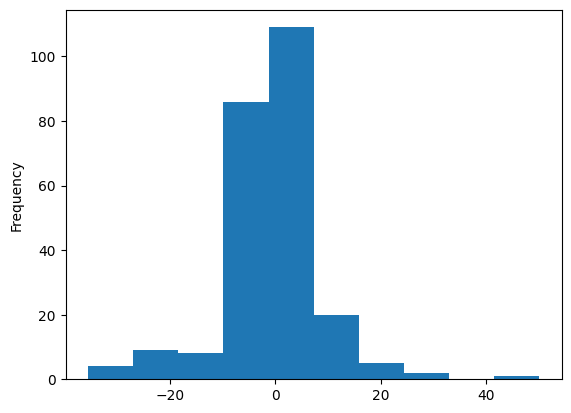

In [321]:
df["Trend (season 13)"].plot.hist() # moze median

<Axes: ylabel='Frequency'>

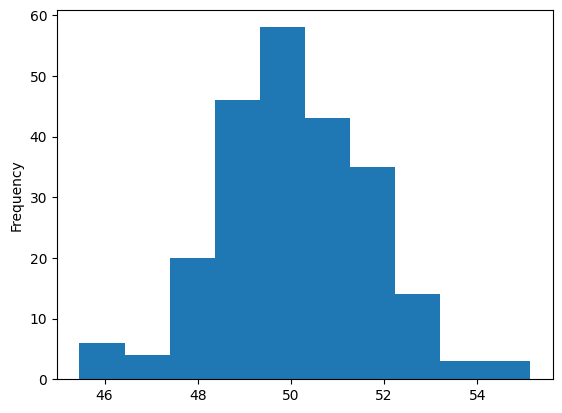

In [322]:
df["Win % (season 12)"].plot.hist() # moze median

<Axes: ylabel='Frequency'>

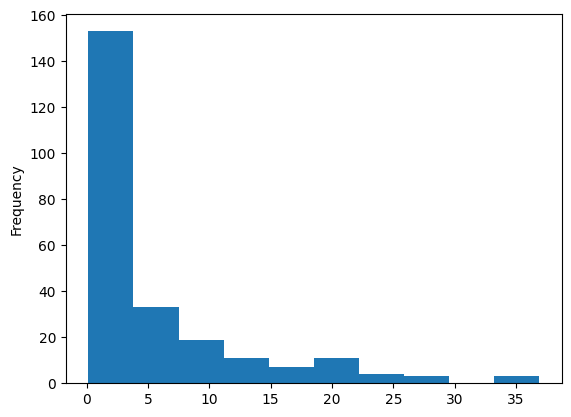

In [323]:
df["Ban % (season 13)"].plot.hist() # moze median

In [324]:
df["Tier (season 13)"].value_counts() # ke mi treba za target, ke go razgledam posle

Tier (season 13)
A     61
B     61
C     37
S     36
D     25
S+    24
Name: count, dtype: int64

In [325]:
median_imputer = SimpleImputer(strategy="median")
cols = ["Trend (season 12)", "Trend (season 13)", 
        "Win % (season 12)", "Win % (season 13)",
        "Ban % (season 12)", "Ban % (season 13)"]
for col in cols:
    df[[col]] = median_imputer.fit_transform(df[[col]])


In [326]:
assert len(df[df["Tier (season 13)"].isna() & 
    df["Tier (season 12)"].isna()]) == 0

# nema niedno kaj so dvete se nan 

In [ ]:
tier_season_12 = df["Tier (season 12)"]
tier_season_13 = df["Tier (season 13)"]
target_vals = []
for i in range(len(df)):
    tier_12 = tier_season_12[i]
    tier_13 = tier_season_13[i]
    
    # bidejki imame stringovi namesto da proveruvam dali e nan proveruvam dali e float, ako e float znaci deka e nan

    predicate1 = type(tier_12) != float and tier_12 == "S+" 
    predicate2 = type(tier_13) != float and tier_13 in ["S", "S+"]

    target_vals.append(1 if predicate1 or predicate2 else 0) 
    
df.drop(columns=["Tier (season 12)", "Tier (season 13)"], inplace=True)
df["World Cup Suitable"] = target_vals

In [244]:
df.head()

,Name,Role,Class (season 12),Trend (season 12),Win % (season 12),Role % (season 12),Pick % (season 12),Ban % (season 12),KDA (season 12),Class (season 13),Trend (season 13),Win % (season 13),Role % (season 13),Pick % (season 13),Ban % (season 13),KDA (season 13),World Cup Suitable
0,Aatrox,TOP,1.0,6.52,49.97,94.62,4.43,2.03,1.97,1.0,-31.86,47.68,91.63,6.62,11.98,1.77,1
1,Ahri,MID,2.0,-0.24,49.93,93.47,4.62,1.04,2.56,2.0,4.55,49.50,94.65,5.81,1.73,2.58,1
2,Akali,MID,0.0,6.51,48.59,65.65,8.16,12.88,2.34,0.0,4.33,48.41,75.74,8.11,13.02,2.37,1
3,Akali,TOP,0.0,3.34,48.57,34.06,4.24,12.88,2.04,0.0,-1.51,45.92,23.50,2.55,13.02,2.00,0
4,Akshan,MID,3.0,0.65,51.46,58.01,4.83,21.91,2.23,3.0,0.34,51.62,66.03,2.75,3.79,2.26,0


In [ ]:
df.isna().sum()

Name                  0
Role                  0
Class (season 12)     0
Trend (season 12)     0
Win % (season 12)     0
Role % (season 12)    0
Pick % (season 12)    0
Ban % (season 12)     0
KDA (season 12)       0
Class (season 13)     0
Trend (season 13)     0
Win % (season 13)     0
Role % (season 13)    0
Pick % (season 13)    0
Ban % (season 13)     0
KDA (season 13)       0
World Cup Suitable    0
dtype: int64

In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                258 non-null    object 
 1   Role                258 non-null    object 
 2   Class (season 12)   258 non-null    float64
 3   Trend (season 12)   258 non-null    float64
 4   Win % (season 12)   258 non-null    float64
 5   Role % (season 12)  258 non-null    float64
 6   Pick % (season 12)  258 non-null    float64
 7   Ban % (season 12)   258 non-null    float64
 8   KDA (season 12)     258 non-null    float64
 9   Class (season 13)   258 non-null    float64
 10  Trend (season 13)   258 non-null    float64
 11  Win % (season 13)   258 non-null    float64
 12  Role % (season 13)  258 non-null    float64
 13  Pick % (season 13)  258 non-null    float64
 14  Ban % (season 13)   258 non-null    float64
 15  KDA (season 13)     258 non-null    float64
 16  World Cu

In [252]:
len(df["Name"].unique())

162

In [253]:
df.drop(columns=["Name"], inplace=True)

In [255]:
len(df["Role"].unique())

5

In [ ]:
df["Role"].value_counts()

Role
TOP        64
MID        64
SUPPORT    51
JUNGLE     50
ADC        29
Name: count, dtype: int64

In [257]:
label_encoder = LabelEncoder()
df["Role"] = label_encoder.fit_transform(df["Role"])
df["Role"].value_counts()

Role
4    64
2    64
3    51
1    50
0    29
Name: count, dtype: int64

In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Role                258 non-null    int64  
 1   Class (season 12)   258 non-null    float64
 2   Trend (season 12)   258 non-null    float64
 3   Win % (season 12)   258 non-null    float64
 4   Role % (season 12)  258 non-null    float64
 5   Pick % (season 12)  258 non-null    float64
 6   Ban % (season 12)   258 non-null    float64
 7   KDA (season 12)     258 non-null    float64
 8   Class (season 13)   258 non-null    float64
 9   Trend (season 13)   258 non-null    float64
 10  Win % (season 13)   258 non-null    float64
 11  Role % (season 13)  258 non-null    float64
 12  Pick % (season 13)  258 non-null    float64
 13  Ban % (season 13)   258 non-null    float64
 14  KDA (season 13)     258 non-null    float64
 15  World Cup Suitable  258 non-null    int64  
dtypes: float

In [259]:
TARGET = "World Cup Suitable"
df[TARGET].value_counts()

World Cup Suitable
0    194
1     64
Name: count, dtype: int64

In [290]:
target_0 = df[df[TARGET] == 0].sample(100)
target_1 = df[df[TARGET] == 1]

In [291]:
final_df = pd.concat([target_0, target_1], ignore_index=True) # pazi ignore index e mn bitno 
final_df = final_df.sample(len(final_df))
final_df.head()

,Role,Class (season 12),Trend (season 12),Win % (season 12),Role % (season 12),Pick % (season 12),Ban % (season 12),KDA (season 12),Class (season 13),Trend (season 13),Win % (season 13),Role % (season 13),Pick % (season 13),Ban % (season 13),KDA (season 13),World Cup Suitable
141,4,1.0,15.560,49.600,83.89,8.23,7.37,1.76,1.0,-9.00,50.30,81.83,7.40,4.49,1.78,1
58,2,2.0,5.180,50.920,91.35,3.43,3.03,2.22,2.0,-0.67,51.52,90.90,3.69,3.69,2.35,0
95,3,4.0,2.270,50.230,98.67,4.05,1.00,2.97,4.0,-0.29,50.30,97.18,3.25,0.48,3.10,0
85,2,5.0,-4.650,49.570,17.42,0.55,0.95,2.37,5.0,-1.60,53.13,20.82,0.45,0.76,2.47,0
38,2,3.0,-0.815,49.885,11.07,0.17,2.39,2.29,3.0,-9.78,51.07,11.07,0.17,0.60,2.29,0


In [292]:
X_train, X_test, Y_train, Y_test = train_test_split(final_df[final_df.columns[:-1]],  final_df[TARGET], test_size=0.2)

In [338]:
from xgboost import XGBClassifier

model = XGBClassifier(max_depth=50, min_child_weight=1, n_estimators=200, n_jobs=-1, verbose=1, learning_rate=0.16)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

/Users/Filip/Desktop/faks/semestar-5/vnp/VNP_2025-26/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [18:59:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [339]:
from sklearn import metrics
print("Accuracy:", metrics.accuracy_score(Y_test, y_pred))

print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

Accuracy: 0.9696969696969697
[[18  1]
 [ 0 14]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.93      1.00      0.97        14

    accuracy                           0.97        33
   macro avg       0.97      0.97      0.97        33
weighted avg       0.97      0.97      0.97        33

